In [13]:
#General Libraries for 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error
import statsmodels.tsa.statespace.sarimax

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

# Libraries Specifically for Neural Nets:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from tensorflow import keras



No Warning Shown


In [3]:
acc_growers = [73177, 91259, 66015, 60706, 399593]

In [4]:
def sarimax_vs_lstm(RegionID, graph="Go", run=1):
    
    #Pulling Data
    
    test_df = pd.read_csv(f'{RegionID}.csv')

    test_df['time'] = pd.to_datetime(test_df['time'])

    test_df.set_index('time', inplace = True)

    test_df.columns = ['Drop', 'RegionName', 'RegionID', 'SizeRank', 'City', 'State',
           'Metro', 'CountyName', 'value']

    test_df.drop('Drop', axis = 'columns', inplace = True)
    
    #Preparing X_train and y_train

    X_train = test_df[['value']].head(len(test_df) - 12)
    y_train = test_df[['value']].tail(12)
    
    #Scale Values

    scaler = MinMaxScaler()

    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    y_train_scaled = scaler.transform(y_train)
    
    #Time Series Genertor

    n_input = 12
    n_features = 1
    generator = TimeseriesGenerator(X_train_scaled, X_train_scaled, length=n_input, batch_size=1)

    #Building Actual Model

    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    #Fitting Model
    
    model.fit(generator, epochs = 32, verbose=0)
    
    #Getting Predictions
    
    test_predictions = []

    first_eval_batch = X_train_scaled[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(y_train_scaled)):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    #Inverse Transforming Preds into Timeseries Data:
    
    preds = scaler.inverse_transform(test_predictions)

    y_train['time'] = y_train.index

    f_steps = y_train[['time']]

    f_steps.index = [0,1,2,3,4,5,6,7,8,9,10,11]

    preds = pd.DataFrame(preds)

    preds = pd.concat([preds, f_steps], axis=1)

    preds['time'] = pd.to_datetime(preds['time'])

    preds.set_index('time', inplace = True)

    preds.columns = ['value']

    #Retrieving Sarimax Preds from Database
    
    sarimax_preds = pd.read_csv(f'{RegionID}_preds.csv')

    sarimax_preds.columns=['time', 'value']

    sarimax_preds['time'] = pd.to_datetime(sarimax_preds['time'])

    sarimax_preds.set_index('time', inplace = True)

    sarimax_preds
    
    # Showing Results
    
    y_train_iso = y_train[['value']]
    
    nn_mae = mean_absolute_error(preds, y_train_iso)
    
    if graph=="Go":
    
        plt.plot(preds, color='green')
        plt.plot(y_train_iso, color='blue')
        plt.plot(sarimax_preds, color ='purple')
        plt.title(f'{RegionID} Comparative Analysis')

        print(f'Mean Absolute Error for {RegionID} Neural Net: {mean_absolute_error(preds, y_train_iso)}')
        print(f'mean Absolute Error for {RegionID} SARIMAX: {mean_absolute_error(sarimax_preds, y_train_iso)}')
        
    else:
        
        model.save(f'{RegionID}_model_{run}.h5')  # creates a HDF5 file 'my_model.h5'
    #         del model  # deletes the existing model
    
        return nn_mae
        
        

In [5]:
sarimax_vs_lstm(73177, graph="Stop", run=1)

2021-10-25 16:44:15.770473: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-25 16:44:15.903719: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1117.8625139097373

In [12]:
# reconstructed_model = keras.models.load_model("73177_model_1.h5")

In [14]:
#Pulling Data

def reconstructed_test(RegionID, run):

    reconstructed_model = keras.models.load_model(f"{RegionID}_model_{run}.h5")

    test_df = pd.read_csv(f'{RegionID}.csv')

    test_df['time'] = pd.to_datetime(test_df['time'])

    test_df.set_index('time', inplace = True)

    test_df.columns = ['Drop', 'RegionName', 'RegionID', 'SizeRank', 'City', 'State',
           'Metro', 'CountyName', 'value']

    test_df.drop('Drop', axis = 'columns', inplace = True)

    #Preparing X_train and y_train

    X_train = test_df[['value']].head(len(test_df) - 12)
    y_train = test_df[['value']].tail(12)

    #Scale Values

    scaler = MinMaxScaler()

    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    y_train_scaled = scaler.transform(y_train)

    #Time Series Genertor

    n_input = 12
    n_features = 1
    generator = TimeseriesGenerator(X_train_scaled, X_train_scaled, length=n_input, batch_size=1)

    #Getting Predictions

    test_predictions = []

    first_eval_batch = X_train_scaled[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(y_train_scaled)):

        # get the prediction value for the first batch
        current_pred = reconstructed_model.predict(current_batch)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    #Inverse Transforming Preds into Timeseries Data:

    preds = scaler.inverse_transform(test_predictions)

    y_train['time'] = y_train.index

    f_steps = y_train[['time']]

    f_steps.index = [0,1,2,3,4,5,6,7,8,9,10,11]

    preds = pd.DataFrame(preds)

    preds = pd.concat([preds, f_steps], axis=1)

    preds['time'] = pd.to_datetime(preds['time'])

    preds.set_index('time', inplace = True)

    preds.columns = ['value']

    #Retrieving Sarimax Preds from Database

    sarimax_preds = pd.read_csv(f'73177_preds.csv')

    sarimax_preds.columns=['time', 'value']

    sarimax_preds['time'] = pd.to_datetime(sarimax_preds['time'])

    sarimax_preds.set_index('time', inplace = True)

    sarimax_preds

    # Showing Results

    y_train_iso = y_train[['value']]
    
    nn_mae = mean_absolute_error(preds, y_train_iso)

    plt.plot(y_train_iso, color='blue', label='Actuals')
    plt.plot(sarimax_preds, color='purple', label='SARIMAX')
    plt.plot(preds, color='green', label='Neural Net')
    plt.title(f'Results for Region: {RegionID}')
    plt.legend()
    
    print(f'Mean Absolute Error of {nn_mae}')

Mean Absolute Error of 16544.22244131565


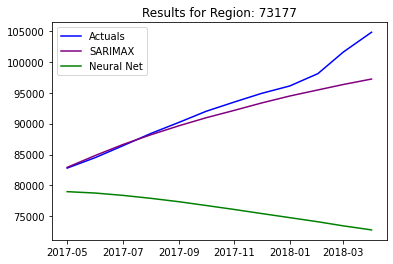

In [15]:
reconstructed_test(73177, 2)

In [12]:
# results = []

# for region in acc_growers:
#     for item in [1,2,3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20]:
#         nn_mae = sarimax_vs_lstm(region, graph="Stop", run=item)
#         results.append([region, item, nn_mae])
#         print([region, nn_mae, item])


In [28]:
# best_models = []

# for item in acc_growers:
#     df = print_best_model(item)
#     best_models.append([round(df.iloc[0]['RegionID']), round(df.iloc[0]['Run']), round(df.iloc[0]['MAE'],2)])
    
# best_models = pd.DataFrame(best_models)

# best_models.columns = ['RegionID', 'Run', 'MAE']

# best_models

# best_models_stored = []

best_nn_models = pd.read_excel('Best NN Models.xlsx').iloc[:,1:]

best_nn_models

,RegionID,Run,MAE
0,73177,18,848.61
1,91259,10,1173.71
2,66015,3,746.66
3,60706,9,7711.63
4,399593,5,4343.45


Mean Absolute Error of 848.6076898872852


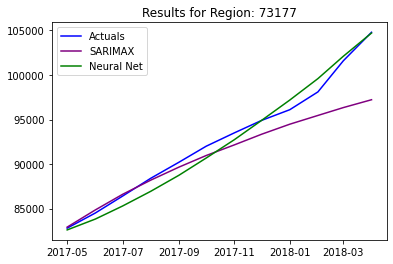

In [17]:
reconstructed_test(73177, 18)

Mean Absolute Error of 1173.708751797676


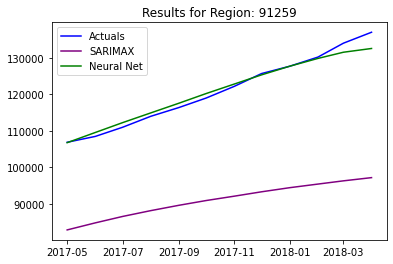

In [18]:
reconstructed_test(91259, 10)

Mean Absolute Error of 746.6633679966131


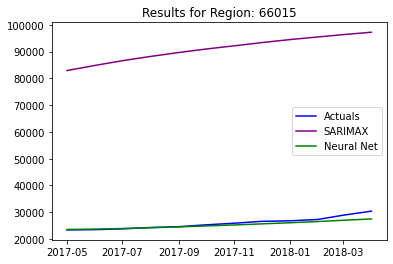

In [19]:
reconstructed_test(66015, 3)

Mean Absolute Error of 7711.633028214176


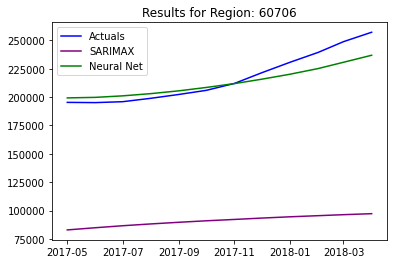

In [20]:
reconstructed_test(60706, 9)

Mean Absolute Error of 4343.453592558687


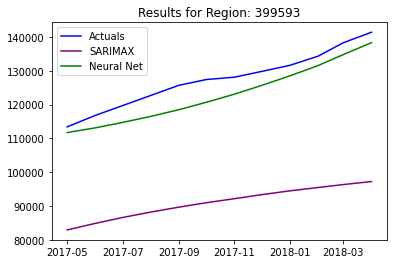

In [21]:
reconstructed_test(399593, 5)

In [31]:
acc_growers_df

,RegionID,City,State,Metro,CountyName,MAE,Comp Error
0,73177,Holiday,FL,Tampa,Pasco,1872.961447,0.02
1,91259,Fort Worth,TX,Dallas-Fort Worth,Tarrant,4541.077453,0.04
2,66015,Reading,PA,Reading,Berks,1921.952964,0.08
3,60706,Paterson,NJ,New York,Passaic,16572.053604,0.08
4,399593,Southfield,MI,Detroit,Oakland,10998.247600,0.09


In [39]:
#Comparisson of Models

acc_growers_df = pd.read_excel('acc_growers.xlsx').iloc[:,1:]

#Joining Models

sarimax_vs_nn = acc_growers_df.merge(best_nn_models, how='inner', left_on='RegionID', right_on='RegionID')

sarimax_vs_nn.columns = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'Sarimax MAE', 'Comp Error', 'Model', 'Neural Net MAE']

sarimax_vs_nn[['RegionID', 'Sarimax MAE', 'Neural Net MAE']]

,RegionID,Sarimax MAE,Neural Net MAE
0,73177,1872.961447,848.61
1,91259,4541.077453,1173.71
2,66015,1921.952964,746.66
3,60706,16572.053604,7711.63
4,399593,10998.247600,4343.45


Text(0, 0.5, 'Mean Absolute Error')

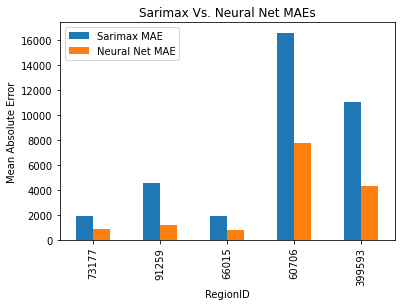

In [51]:
sarimax_vs_nn.plot(x="RegionID", y=["Sarimax MAE", "Neural Net MAE"], kind="bar")
plt.title('Sarimax Vs. Neural Net MAEs')
plt.ylabel('Mean Absolute Error')